# Heterogeneous Treatment Effect Estimation with Meta Learners

## Spotify's In-app messaging
- Spotify uses in app-messaging to advertise Spotify Premium to users
- Some users might get conviced by it
- Others might react negatively
- Goal: Converting as many users as possible without losing free users
![spotify](spotify.png)

## Personalized Discounts
- Giving out discounts can increase number of customers
- Giving discounts to customers who would buy the product whether or not they get a discount however decreases their spendings
- Some might get annoyed by constant marketing emails
- Goal: find the customers worth giving discounts to
![discounts](discounts.png)


## Definitions
Heterogeneous treatment effect estimation is part of causal inference, that aims to estimate how different individuals respond to a treatment
Conditional Average Treatment Effect (CATE) is the expected difference in an individual’s outcome when they receive the treatment compared to when they don’t

$$\tau(x) = \mathbb{E}[Y(1) - Y(0) | X = x].$$


In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from bayesian_hte import bayesian_meta_learners, meta_learners, pymc_models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate synthetic data

In [2]:
def non_linear_fn(x):
    return 3 * np.sin(3 * x) + 2 * np.sin(2 * x)

np.random.seed(0)

n = 1000
p = 4

X = np.random.normal(size=(n, p))
treatment_prob_beta = np.random.normal(size=p)
treatment_probability = 1 / (1 + np.exp(-X @ treatment_prob_beta))

treatment = np.random.binomial(1, treatment_probability)
effect_beta = np.random.normal(size=p)
effect = X @ np.abs(effect_beta)

exog_beta = np.random.normal(size=p)
exog = non_linear_fn(X @ exog_beta)

y = exog + treatment * effect + 0.5 * np.random.normal(size=n)

print("Treatment proportion", treatment.mean())
print("Average treatment effect", effect.mean())

y = pd.Series(y)
treatment = pd.Series(treatment)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(p)])

Treatment proportion 0.48
Average treatment effect -0.012397647787463342


## Meta learners implemented
- S-learner
- T-learner
- X-learner
- DR-learner

All models have a frequentist and a Bayesian version.

In [3]:
meta_learner = meta_learners.DRLearner(model=RandomForestRegressor())
meta_learner.fit(X, y, treatment)

In [4]:
meta_learner.summary()

╔════════════════════════════════════════════════════════╗
    ║ Conditional Average Treatment Effect Estimator Summary ║
    ╚════════════════════════════════════════════════════════╝
    
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┱───────────────────────────────┐
    ┃     Number of observations    ┃              1000             │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┤
    ┃ Number of treated observations┃              480              │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┤
    ┃Average treatement effect (ATE)┃              0.34             │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┤
    ┃95% Confidence interval for ATE┃         (-0.68, 0.65)         │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┤
    ┃         Estimated bias        ┃              -0.3             │
    ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┹───────────────────────────────┘
    ╔═══════════════╗
    ║ Base learners ║
    ╚═══════════════╝
    
                                    ╔═══════════════════════════════╦═══════════════════════════════╗
                                    ║             Model             ║              R^2              ║
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╚═══════════════════════════════╩═══════════════════════════════╝    
    ┃            treated            ┃     RandomForestRegressor     │              0.67             │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┼───────────────────────────────┤
    ┃           untreated           ┃     RandomForestRegressor     │              0.54             │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┼───────────────────────────────┤
    ┃           propensity          ┃       LogisticRegression      │              0.8              │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────┼───────────────────────────────┤
    ┃         pseudo_outcome        ┃     RandomForestRegressor     │              0.46             │
    ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┹───────────────────────────────┴───────────────────────────────┘

/Users/matekadlicsko/Desktop/project/bayesian-hte/notebooks/../bayesian_hte/base.py:422: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("quantile")


(<Figure size 2000x2000 with 2 Axes>,
 array([<Axes: title={'center': 'Uplift by quantile'}, xlabel='quantile'>,
        <Axes: title={'center': 'Cumulative uplift'}, xlabel='Percentage of population', ylabel='Uplift'>],
       dtype=object))

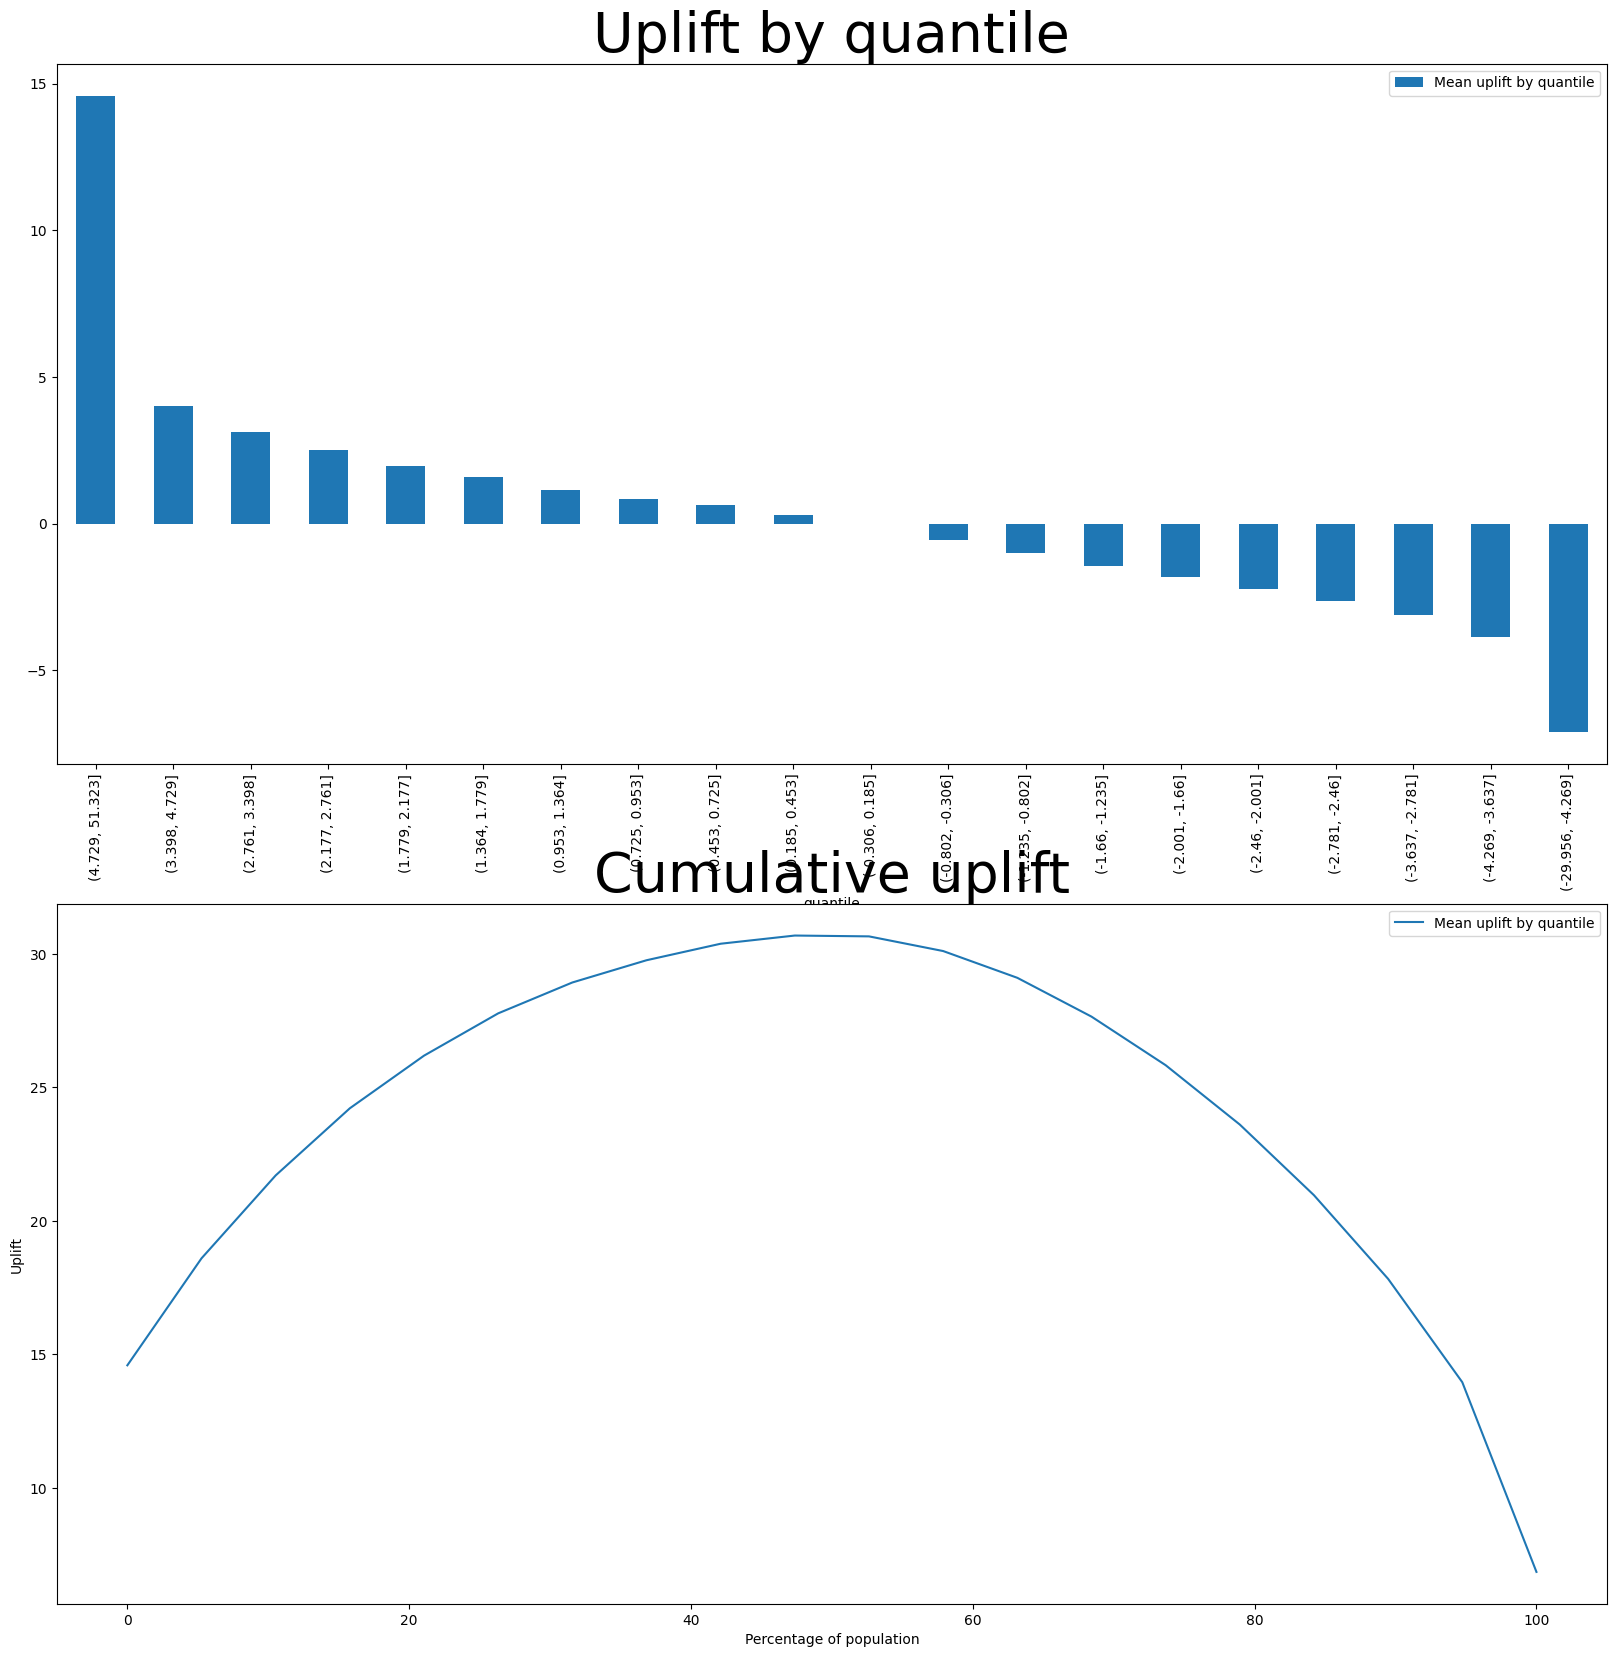

In [5]:
meta_learner.plot()

In [6]:
bslearner = bayesian_meta_learners.BayesianSLearner(
    model=pymc_models.BARTRegressor()
).fit(X, y, treatment)

bslearner.summary()

/Users/matekadlicsko/Desktop/project/bayesian-hte/.venv/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Output()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [mu, y_hat]
Sampling: [y_hat]
Sampling: [mu, y_hat]
Sampling: [mu, y_hat]
Sampling: [mu, y_hat]
Sampling: [mu, y_hat]


╔════════════════════════════════════════════════════════╗
    ║ Conditional Average Treatment Effect Estimator Summary ║
    ╚════════════════════════════════════════════════════════╝
    
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┱──────────────────────────────────────────┐
    ┃          Number of observations          ┃                   1000                   │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋──────────────────────────────────────────┤
    ┃      Number of treated observations      ┃                   480                    │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋──────────────────────────────────────────┤
    ┃     Average treatement effect (ATE)      ┃            0.1714591069064407            │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋──────────────────────────────────────────┤
    ┃               HDI for ATE                ┃(-0.1070785675254789, 0.40713646412168386)│
    ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┹──────────────────────────────────────────┘
    ╔═══════════════╗
    ║ Base learners ║
    ╚═══════════════╝

In [7]:
bslearner.summary()

Sampling: [mu, y_hat]
Sampling: [mu, y_hat]


╔════════════════════════════════════════════════════════╗
    ║ Conditional Average Treatment Effect Estimator Summary ║
    ╚════════════════════════════════════════════════════════╝
    
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┱───────────────────────────────────────────┐
    ┃           Number of observations          ┃                    1000                   │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────────────────┤
    ┃       Number of treated observations      ┃                    480                    │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────────────────┤
    ┃      Average treatement effect (ATE)      ┃             0.1714591069064407            │
    ┣━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋───────────────────────────────────────────┤
    ┃                HDI for ATE                ┃(-0.08195127670096503, 0.42669055228757485)│
    ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┹───────────────────────────────────────────┘
    ╔═══════════════╗
    ║ Base learners ║
    ╚═══════════════╝